In [ ]:
!pip install POT

In [ ]:
import pandas as pd
import numpy as np
import gdown
import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from scipy.spatial.distance import jaccard, dice, hamming
from scipy.stats import pearsonr, entropy
from sklearn.cluster import KMeans
from gensim.corpora import Dictionary
from gensim.similarities import WmdSimilarity
from gensim.models import KeyedVectors
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

url = "https://drive.google.com/file/d/1y9qBtV71aY6OtEnhfQAxMTWXBBmdv63i/view?usp=drive_link"
output = "dataset.csv"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1y9qBtV71aY6OtEnhfQAxMTWXBBmdv63i
To: /content/dataset.csv
100%|██████████| 93.0M/93.0M [00:01<00:00, 65.7MB/s]


'dataset.csv'

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import dataset

In [ ]:
pd.set_option("display.max_colwidth",None)

In [ ]:
dataset = pd.read_csv("dataset.csv")

# Modeling

In [ ]:
input_text = "At the age of 28, I, John Smith, am an enthusiastic and highly skilled data analyst seeking to advance my career by applying for a position in the data field. With over five years of experience in data analysis and a proven track record of successfully implementing data-driven strategies, I have honed my expertise in various analytical tools and methodologies. I hold a Bachelor's degree in Computer Science from the University of California, Berkeley, and a Master's degree in Data Science from Stanford University. Throughout my career, I have demonstrated exceptional analytical capabilities, strong problem-solving skills, and a deep understanding of statistical models and machine learning algorithms. My passion for uncovering insights from complex datasets and my commitment to continuous learning make me a valuable candidate for any data-driven organization."

In [ ]:
input_text = input_text.lower()

In [ ]:
input_text = re.sub(r'[^\w\s]', '', input_text)

In [ ]:
tokens = word_tokenize(input_text)

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
tokens = [word for word in tokens if word not in stop_words]

In [ ]:
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(word) for word in tokens]
input_text = ' '.join(tokens)

In [ ]:
model = api.load("word2vec-google-news-300")

In [ ]:
def get_average_word2vec(tokens, model, num_features):
    valid_words = [word for word in tokens if word in model]
    if not valid_words:
        return np.zeros(num_features)
    return np.mean([model[word] for word in valid_words], axis=0)

In [ ]:
corpus_tokens = [word_tokenize(re.sub(r'[^\w\s]', '', doc.lower())) for doc in dataset["deskripsi_keterampilan_final"]]
corpus_tokens = [[lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] for tokens in corpus_tokens]

In [ ]:
num_features = 300
corpus_embeddings = np.array([get_average_word2vec(tokens, model, num_features) for tokens in corpus_tokens])

In [ ]:
input_tokens = word_tokenize(input_text)
input_embedding = get_average_word2vec(input_tokens, model, num_features)

In [ ]:
cosine_similarities = cosine_similarity([input_embedding], corpus_embeddings).flatten()

In [ ]:
dataset["cosine_similarity"] = cosine_similarities

In [ ]:
euclidean_distance = euclidean_distances([input_embedding], corpus_embeddings).flatten()

In [ ]:
dataset["euclidean_distance"] = euclidean_distance

In [ ]:
manhattan_distance = manhattan_distances([input_embedding], corpus_embeddings).flatten()

In [ ]:
dataset["manhattan_distance"] = manhattan_distance

In [ ]:
def jaccard_similarity(s1, s2):
    s1 = set(s1.split())
    s2 = set(s2.split())
    return len(s1 & s2) / len(s1 | s2)

In [ ]:
jaccard_similarities = np.array([jaccard_similarity(' '.join(input_tokens), ' '.join(tokens)) for tokens in corpus_tokens])

In [ ]:
dataset["jaccard_similarity"] = jaccard_similarities

In [ ]:
def dice_coefficient(s1, s2):
    s1 = set(s1.split())
    s2 = set(s2.split())
    return 2 * len(s1 & s2) / (len(s1) + len(s2))

In [ ]:
dice_coefficients = np.array([dice_coefficient(' '.join(input_tokens), ' '.join(tokens)) for tokens in corpus_tokens])

In [ ]:
dataset["dice_coefficient"] = dice_coefficients

In [ ]:
def pearson_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0
    return pearsonr(x, y)[0]

In [ ]:
pearson_correlations = np.array([pearson_corr(input_embedding, emb) for emb in corpus_embeddings])

In [ ]:
dataset["pearson_correlation"] = pearson_correlations

In [ ]:
def wmd_distance(s1, s2, model):
    s1_words = s1.split()
    s2_words = s2.split()

    s1_words = [word for word in s1_words if word in model]
    s2_words = [word for word in s2_words if word in model]

    if not s1_words or not s2_words:
        return float('inf')

    return model.wmdistance(s1_words, s2_words)

In [ ]:
wmd_distances = np.array([wmd_distance(' '.join(input_tokens), ' '.join(tokens), model) for tokens in corpus_tokens])

In [ ]:
dataset["wmd_distance"] = wmd_distances

In [ ]:
def bhattacharyya_distance(p, q):
    p = np.sqrt(np.abs(p))
    q = np.sqrt(np.abs(q))
    return -np.log(np.sum(p * q) + 1e-10)

def bhattacharyya_distance_from_vector(x, y):
    p = x / (np.sum(x) + 1e-10)
    q = y / (np.sum(y) + 1e-10)
    return bhattacharyya_distance(p, q)

In [ ]:
bhattacharyya_distances = np.array([bhattacharyya_distance_from_vector(input_embedding, emb) for emb in corpus_embeddings])

In [ ]:
dataset["bhattacharyya_distance"] = bhattacharyya_distances

In [ ]:
def kl_divergence(p, q):
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return entropy(p, q)

In [ ]:
kl_divergences = np.array([kl_divergence(input_embedding, emb) for emb in corpus_embeddings])

In [ ]:
dataset["kl_divergence"] = kl_divergences

# Hasil

In [ ]:
top_similar = dataset.sort_values(by='cosine_similarity', ascending=False).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
13111    3701314004       71049830  Information Technology   
19252    3757450438         871133  Information Technology   
18214    3757459741          53864  Information Technology   
1784     3693049684       18581793      Project Management   
19613    3757709060          23099                 Analyst   
454      3682818140       68921004  Information Technology   
16250    3757444978         164182                Research   
1142     3693046569       10577525      Project Management   
4277     3693581630           2276                 Science   
4486     3693584453           2276                 Science   

                                                              job title  \
13111  data science artificial intelligence machine learning internship   
19252                                                    data scientist   
18214                                                    data scientist   
1784                                                     senior manager   
19613                                                    data scientist   
454                              senior business intelligence developer   
16250                                                  business analyst   
1142                                              data scientist remote   
4277                                              senior data scientist   
4486                                              senior data scientist   

      jenis_pekerjaan   registration_type category sponsor  \
13111      Internship  ComplexOnsiteApply        sponsored   
19252       Full-time  ComplexOnsiteApply    not sponsored   
18214       Full-time        OffsiteApply    not sponsored   
1784        Full-time  ComplexOnsiteApply        sponsored   
19613        Contract  ComplexOnsiteApply    not sponsored   
454          Contract  ComplexOnsiteApply    not sponsored   
16250       Full-time  ComplexOnsiteApply    not sponsored   
1142        Full-time  ComplexOnsiteApply    not sponsored   
4277        Full-time        OffsiteApply        sponsored   
4486        Full-time        OffsiteApply    not sponsored   

                         city       state         county  \
13111  san francisco bay area  california  united states   
19252                new york    new york  united states   
18214                  frisco       texas  united states   
1784   san francisco bay area  california  united states   
19613                 houston       texas  united states   
454                  mckinney       texas  united states   
16250                 chicago    illinois  united states   
1142                 new york    new york  united states   
4277      south san francisco  california  united states   
4486      south san francisco  california  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
top_similar['cosine_similarity']

13111    0.912177
19252    0.909173
18214    0.905357
1784     0.904332
19613    0.902169
454      0.901892
16250    0.901339
1142     0.900614
4277     0.898854
4486     0.898854
Name: cosine_similarity, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='euclidean_distance', ascending=True).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
13111    3701314004       71049830  Information Technology   
19252    3757450438         871133  Information Technology   
18214    3757459741          53864  Information Technology   
1784     3693049684       18581793      Project Management   
454      3682818140       68921004  Information Technology   
19613    3757709060          23099                 Analyst   
4277     3693581630           2276                 Science   
4486     3693584453           2276                 Science   
1142     3693046569       10577525      Project Management   
12771    3701308803       15167200             Engineering   

                                                              job title  \
13111  data science artificial intelligence machine learning internship   
19252                                                    data scientist   
18214                                                    data scientist   
1784                                                     senior manager   
454                              senior business intelligence developer   
19613                                                    data scientist   
4277                                              senior data scientist   
4486                                              senior data scientist   
1142                                              data scientist remote   
12771                                      data analyst remote contract   

      jenis_pekerjaan   registration_type category sponsor  \
13111      Internship  ComplexOnsiteApply        sponsored   
19252       Full-time  ComplexOnsiteApply    not sponsored   
18214       Full-time        OffsiteApply    not sponsored   
1784        Full-time  ComplexOnsiteApply        sponsored   
454          Contract  ComplexOnsiteApply    not sponsored   
19613        Contract  ComplexOnsiteApply    not sponsored   
4277        Full-time        OffsiteApply        sponsored   
4486        Full-time        OffsiteApply    not sponsored   
1142        Full-time  ComplexOnsiteApply    not sponsored   
12771        Contract  ComplexOnsiteApply    not sponsored   

                         city       state         county  \
13111  san francisco bay area  california  united states   
19252                new york    new york  united states   
18214                  frisco       texas  united states   
1784   san francisco bay area  california  united states   
454                  mckinney       texas  united states   
19613                 houston       texas  united states   
4277      south san francisco  california  united states   
4486      south san francisco  california  united states   
1142                 new york    new york  united states   
12771               palo alto  california  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
top_similar = dataset.sort_values(by='manhattan_distance', ascending=True).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
13111    3701314004       71049830  Information Technology   
454      3682818140       68921004  Information Technology   
19252    3757450438         871133  Information Technology   
1784     3693049684       18581793      Project Management   
19613    3757709060          23099                 Analyst   
18214    3757459741          53864  Information Technology   
12771    3701308803       15167200             Engineering   
4277     3693581630           2276                 Science   
4486     3693584453           2276                 Science   
1142     3693046569       10577525      Project Management   

                                                              job title  \
13111  data science artificial intelligence machine learning internship   
454                              senior business intelligence developer   
19252                                                    data scientist   
1784                                                     senior manager   
19613                                                    data scientist   
18214                                                    data scientist   
12771                                      data analyst remote contract   
4277                                              senior data scientist   
4486                                              senior data scientist   
1142                                              data scientist remote   

      jenis_pekerjaan   registration_type category sponsor  \
13111      Internship  ComplexOnsiteApply        sponsored   
454          Contract  ComplexOnsiteApply    not sponsored   
19252       Full-time  ComplexOnsiteApply    not sponsored   
1784        Full-time  ComplexOnsiteApply        sponsored   
19613        Contract  ComplexOnsiteApply    not sponsored   
18214       Full-time        OffsiteApply    not sponsored   
12771        Contract  ComplexOnsiteApply    not sponsored   
4277        Full-time        OffsiteApply        sponsored   
4486        Full-time        OffsiteApply    not sponsored   
1142        Full-time  ComplexOnsiteApply    not sponsored   

                         city       state         county  \
13111  san francisco bay area  california  united states   
454                  mckinney       texas  united states   
19252                new york    new york  united states   
1784   san francisco bay area  california  united states   
19613                 houston       texas  united states   
18214                  frisco       texas  united states   
12771               palo alto  california  united states   
4277      south san francisco  california  united states   
4486      south san francisco  california  united states   
1142                 new york    new york  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
top_similar['manhattan_distance']

13111    5.581746
454      5.741529
19252    5.749671
1784     5.751287
19613    5.771357
18214    5.775800
12771    5.869603
4277     5.914690
4486     5.914690
1142     5.934499
Name: manhattan_distance, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='jaccard_similarity', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
22536,3755577654,2562128,Engineering,senior software scientist medical imaging,Full-time,ComplexOnsiteApply,not sponsored,buffalo grove,illinois,united states,qualification ph master degree computer science software engineering related field prefer exceptional candidate stem area highly encourage apply minimum year hand experience algorithm development primarily c ct medical imaging application deep understanding ct medical image modality proven expertise computer vision machine learning medical image processing strong software design unit test skill knowledge medical terminology biomedical engineering desirable strong publication intellectual property record relate ai medical imaging proficiency program c python additional relevant languages excellent debugging troubleshoot ability familiarity directx firmware game engine image reconstruction matrix inversion lut implementation gpu cpu multithreading experience nvidia object orient coding python familiarity software architectural design design pattern sdlc tcp ip xml schema simulation agile methodology,0.826353,0.585105,8.278525,0.152174,0.264151,0.822982,0.930495,-1.627758,inf
9283,3699055896,51701268,Information Technology,tableau architect,Contract,ComplexOnsiteApply,sponsored,No Info,new jersey,united states,seek experienced senior business intelligence architect strong focus tableau expertise join dynamic team ideal candidate proven track record interpret functional need leading requirement gather session design complex business intelligence system provide valuable insight use tableau seasoned professional extensive experience data analysis dashboard design mentoring encourage apply responsibility interpret functional need translate effective business intelligence solution lead facilitate requirement gather session stakeholder document detailed requirement design architect complex business intelligence system align organizational goal develop impact ful tableau dashboard report use various data source aws sql etc utilize expertise data warehousing tool technique data stage etl tableau prep ensure data quality consistency demonstrate deep understanding data warehouse lifecycle data source etl multidimensional model data mart star schema report provide consulting leadership mentorship junior team member analyze data identify pattern trend insight drive business decision making requirement bachelor degree computer science information technology business related field minimum year overall professional experience building bi report solution extensive experience depth knowledge business intelligence tool architecture least year hand experience tableau design development strong expertise bi design complex system project proficiency design dashboard report use diverse data source include aws sql etc familiarity data warehouse tool technique data stage etl tableau prep thorough understanding data warehouse lifecycle data source etl multidimensional model report exceptional consulting leadership mentor ability,0.881897,0.468128,6.473764,0.144578,0.252632,0.879734,0.905640,-1.735470,inf
12904,3701310859,490432,Engineering,financial planning consultant,Contract,ComplexOnsiteApply,not sponsored,wilmington,delaware,united states,fp consultant wilmington role job description seek highly skilled experienced financial planning analysis fp data architect expertise tool strong background banking financial domain key member team responsible design implementing maintain data architecture responsibility data architecture design collaborate cross functional team understand business requirement design robust data architecture cater financial planning analysis need organization data integration de

In [ ]:
top_similar['jaccard_similarity']

22536    0.152174
9283     0.144578
12904    0.137931
24110    0.134021
17502    0.132184
3405     0.131455
2243     0.128571
24805    0.128571
2312     0.126506
13387    0.126087
Name: jaccard_similarity, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='dice_coefficient', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
22536,3755577654,2562128,Engineering,senior software scientist medical imaging,Full-time,ComplexOnsiteApply,not sponsored,buffalo grove,illinois,united states,qualification ph master degree computer science software engineering related field prefer exceptional candidate stem area highly encourage apply minimum year hand experience algorithm development primarily c ct medical imaging application deep understanding ct medical image modality proven expertise computer vision machine learning medical image processing strong software design unit test skill knowledge medical terminology biomedical engineering desirable strong publication intellectual property record relate ai medical imaging proficiency program c python additional relevant languages excellent debugging troubleshoot ability familiarity directx firmware game engine image reconstruction matrix inversion lut implementation gpu cpu multithreading experience nvidia object orient coding python familiarity software architectural design design pattern sdlc tcp ip xml schema simulation agile methodology,0.826353,0.585105,8.278525,0.152174,0.264151,0.822982,0.930495,-1.627758,inf
9283,3699055896,51701268,Information Technology,tableau architect,Contract,ComplexOnsiteApply,sponsored,No Info,new jersey,united states,seek experienced senior business intelligence architect strong focus tableau expertise join dynamic team ideal candidate proven track record interpret functional need leading requirement gather session design complex business intelligence system provide valuable insight use tableau seasoned professional extensive experience data analysis dashboard design mentoring encourage apply responsibility interpret functional need translate effective business intelligence solution lead facilitate requirement gather session stakeholder document detailed requirement design architect complex business intelligence system align organizational goal develop impact ful tableau dashboard report use various data source aws sql etc utilize expertise data warehousing tool technique data stage etl tableau prep ensure data quality consistency demonstrate deep understanding data warehouse lifecycle data source etl multidimensional model data mart star schema report provide consulting leadership mentorship junior team member analyze data identify pattern trend insight drive business decision making requirement bachelor degree computer science information technology business related field minimum year overall professional experience building bi report solution extensive experience depth knowledge business intelligence tool architecture least year hand experience tableau design development strong expertise bi design complex system project proficiency design dashboard report use diverse data source include aws sql etc familiarity data warehouse tool technique data stage etl tableau prep thorough understanding data warehouse lifecycle data source etl multidimensional model report exceptional consulting leadership mentor ability,0.881897,0.468128,6.473764,0.144578,0.252632,0.879734,0.905640,-1.735470,inf
12904,3701310859,490432,Engineering,financial planning consultant,Contract,ComplexOnsiteApply,not sponsored,wilmington,delaware,united states,fp consultant wilmington role job description seek highly skilled experienced financial planning analysis fp data architect expertise tool strong background banking financial domain key member team responsible design implementing maintain data architecture responsibility data architecture design collaborate cross functional team understand business requirement design robust data architecture cater financial planning analysis need organization data integration de

In [ ]:
top_similar['dice_coefficient']

22536    0.264151
9283     0.252632
12904    0.242424
24110    0.236364
17502    0.233503
3405     0.232365
2243     0.227848
24805    0.227848
2312     0.224599
13387    0.223938
Name: dice_coefficient, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='pearson_correlation', ascending=False).head(10)
top_similar

id_pekerjaan  id_perusahaan                   skill  \
13111    3701314004       71049830  Information Technology   
19252    3757450438         871133  Information Technology   
18214    3757459741          53864  Information Technology   
1784     3693049684       18581793      Project Management   
19613    3757709060          23099                 Analyst   
454      3682818140       68921004  Information Technology   
16250    3757444978         164182                Research   
1142     3693046569       10577525      Project Management   
4486     3693584453           2276                 Science   
4277     3693581630           2276                 Science   

                                                              job title  \
13111  data science artificial intelligence machine learning internship   
19252                                                    data scientist   
18214                                                    data scientist   
1784                                                     senior manager   
19613                                                    data scientist   
454                              senior business intelligence developer   
16250                                                  business analyst   
1142                                              data scientist remote   
4486                                              senior data scientist   
4277                                              senior data scientist   

      jenis_pekerjaan   registration_type category sponsor  \
13111      Internship  ComplexOnsiteApply        sponsored   
19252       Full-time  ComplexOnsiteApply    not sponsored   
18214       Full-time        OffsiteApply    not sponsored   
1784        Full-time  ComplexOnsiteApply        sponsored   
19613        Contract  ComplexOnsiteApply    not sponsored   
454          Contract  ComplexOnsiteApply    not sponsored   
16250       Full-time  ComplexOnsiteApply    not sponsored   
1142        Full-time  ComplexOnsiteApply    not sponsored   
4486        Full-time        OffsiteApply    not sponsored   
4277        Full-time        OffsiteApply        sponsored   

                         city       state         county  \
13111  san francisco bay area  california  united states   
19252                new york    new york  united states   
18214                  frisco       texas  united states   
1784   san francisco bay area  california  united states   
19613                 houston       texas  united states   
454                  mckinney       texas  united states   
16250                 chicago    illinois  united states   
1142                 new york    new york  united states   
4486      south san francisco  california  united states   
4277      south san francisco  california  united states   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
top_similar['pearson_correlation']

13111    0.910623
19252    0.907933
18214    0.903591
1784     0.902691
19613    0.901016
454      0.900092
16250    0.899521
1142     0.898786
4486     0.896960
4277     0.896960
Name: pearson_correlation, dtype: float64

In [ ]:
filtered_dataset = dataset[dataset["wmd_distance"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='wmd_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
19252,3757450438,871133,Information Technology,data scientist,Full-time,ComplexOnsiteApply,not sponsored,new york,new york,united states,henderson harbor group premier executive search consult firm deep experience technology finance accounting tax search division recruit highly skilled professional direct hire basis service client primarily tri state area well nationally aafa npa network data scientist forefront data drive decision make process work closely cross functional team extract valuable insight data build predictive model provide actionable recommendation drive business forward key responsibilities collect pre process data various source ensure data quality accuracy explore analyze visualize data identify trend pattern insight develop machine learning model algorithm predictive prescriptive analytics collaborate domain expert stakeholder define business problem objective design experiment conduct statistical analysis test hypothesis validate model evaluate select appropriate tool framework library data analysis model create data drive report dashboard communicate finding recommendation stay date latest data science technique technology participate development data science strategy road maps contribute data related project mentor junior data scientist provide technical guidance maintain strong focus data privacy ethic compliance qualifications bachelor master degree quantitative field computer science statistic data science proven experience data scientist similar role proficiency data analysis visualization tool python r sql strong knowledge machine learning statistic data mining experience data manipulation modeling library e g panda sci kit learn tensor flow strong problem solving analytical skill excellent communication presentation skill ability work effectively collaborative team environment knowledge big data technology distribute computing plus industry specific experience may require base role e g healthcare finance e commerce etc,0.909173,0.411585,5.749671,0.125000,0.222222,0.907933,0.886194,-1.843796,inf
18373,3757469023,16198010,Sales,next generation data analyst site new york city,Full-time,ComplexOnsiteApply,not sponsored,new york,new york,united states,seek talented forward think next generation data analyst join team next generation data analyst play crucial role shape future data analysis within organization primary responsibility collaborate closely leadership understand business need identify data driven insight stay abreast industry trend emerge technology best practice data analysis position require deep understanding data analysis excellent problem solve skill hand experience key responsibility collaboration leadership work closely leadership understand business objective provide data driven insight inform decision making process present analysis finding recommendation leadership clear concise manner facilitate data drive discussion strategic planning assist ceo identify key performance indicator kpis metric measure success business strategy contribute develop data driven strategy initiative enhance business performance competitiveness data visualization create visually appeal easy understand dashboard chart report communicate complex data insight stakeholder use data visualization tool present finding compelling impact ful manner clean pre process analyze large datasets extract valuable pattern trend insight build deploy machine learning model various application predictive analytics recommendation system anomaly detection utilize statistical method tool validate model ensure accuracy reliability data quality integrity ensure data accuracy completeness consistency implement quality check validation

In [ ]:
top_similar['wmd_distance']

19252    0.886194
18373    0.904080
9283     0.905640
12904    0.909893
28867    0.913993
17502    0.915782
18214    0.918654
1784     0.923813
1885     0.926653
2312     0.928276
Name: wmd_distance, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='bhattacharyya_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
1521,3693048426,18953334,Design,bridal stylist,Part-time,ComplexOnsiteApply,not sponsored,san francisco bay area,california,united states,responsibility lead co lead styling appointment bride guest stay update brand product knowledge include bridal trend prepare appointment style fit communicate bride appointment provide outstanding customer service qualification retail sale experience must weekend friday sunday availability interest bridal fashion positive energize attitude,0.599065,0.862452,11.561216,0.009709,0.019231,0.604292,1.199482,-4.563009,inf
10382,3699085913,28389122,Business Development,business development manager,Full-time,ComplexOnsiteApply,not sponsored,salt lake city,utah,united states,client full service logistics provider seek business development manager join team salt lake city area business development manager responsible identify pursue new business opportunity develop implement sale strategy build relationship client prospect requirement minimum year experience business development salt lake city area must international freight forwarding logistics industry air ocean benefit competitive salary package attractive commission program gross profit dollar one cap sunset car allowance business relate travel comprehensive medical dental retirement plan sound like perfect fit hesitate apply relative title include sale representative account executive business development executive sale associate sale manager sale account manager sale development representative sale account executive sale relationship manager sale development executive national account manager sale business development manager new business development manager account development manager business development executive business development manager international sale manager global sale manager senior account executive sale executive sale account executive national business development manager director business development global sale executive strategic account executive,0.545359,0.938096,13.201450,0.021127,0.041379,0.550032,1.213831,-4.090725,inf
6504,3694107931,2678,Quality Assurance,producciónorth general,Full-time,OffsiteApply,not sponsored,dayton,virginia,united states,un más sus ten table cultivar tu carrera al global de cargill que con que en usar man eras sus ten tables de nut rir al mundo este puesto está den tro del de sal de cargill con el que ali men tic ios de alta cali dad una amp lia gama de oper adores de de de comestible fabric antes export adores dayton va tipo de emp leo tiempo comp leto tiempo medio hr bono de bene fic ios dental de la vista marathon health clinic centro de salud por el pag adas k con contrib uci ones de cargill de fsas de de vida de asistencia al eap de des cuentos para res pons abi lid ades mane jar pavo la el área de trabajo e legal para en los estados unidos sin la de un de visa mayor de años de edad pre via en de pavo en de en de de trabajo en los los una llamada telef nica de un de área en que esta el de la con igualdad de,0.196299,1.796636,25.055556,0.000000,0.000000,0.198249,1.294562,-3.838164,inf
5547,3694100610,81219955,Health Care Provider,psychotherapist private practice,Full-time,SimpleOnsiteApply,not sponsored,brooklyn,new york,united states,ffs start see com detail,0.373018,1.332740,18.058663,0.000000,0.000000,0.376029,1.292589,-3.751547,inf
18291,3757466489,425698,Information Technology,director franchise sale,Contract,ComplexOnsiteApply,not sponsored,No Info,No Info,united states,job description position director franchise sales duration direct hire location remote job description experience job description the director franchise sale report vice president sale responsible franchise sale activity 

In [ ]:
top_similar['bhattacharyya_distance']

1521    -4.563009
10382   -4.090725
6504    -3.838164
5547    -3.751547
18291   -3.730340
1965    -3.632382
22929   -3.549076
19124   -3.529325
16715   -3.514708
10632   -3.403062
Name: bhattacharyya_distance, dtype: float64

In [ ]:
filtered_dataset = dataset[dataset["kl_divergence"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='kl_divergence', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence


In [ ]:
filtered_dataset = dataset[dataset["kl_divergence"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='kl_divergence', ascending=True).head(10)
top_similar

Series([], Name: kl_divergence, dtype: float64)


In [ ]:
top_cosine = dataset.sort_values(by='cosine_similarity', ascending=False).head(10)
top_euclidean = dataset.sort_values(by='euclidean_distance', ascending=True).head(10)
top_manhattan = dataset.sort_values(by='manhattan_distance', ascending=True).head(10)
top_jaccard = dataset.sort_values(by='jaccard_similarity', ascending=False).head(10)
top_dice = dataset.sort_values(by='dice_coefficient', ascending=False).head(10)
top_pearson = dataset.sort_values(by='pearson_correlation', ascending=False).head(10)
filtered_dataset_wmd = dataset[dataset["wmd_distance"] != float('inf')]
top_wmd = filtered_dataset_wmd.sort_values(by='wmd_distance', ascending=True).head(10)
top_bhattacharyya = dataset.sort_values(by='bhattacharyya_distance', ascending=True).head(10)
filtered_dataset_kl = dataset[dataset["kl_divergence"] != float('inf')]
top_kl = filtered_dataset_kl.sort_values(by='kl_divergence', ascending=True).head(10)

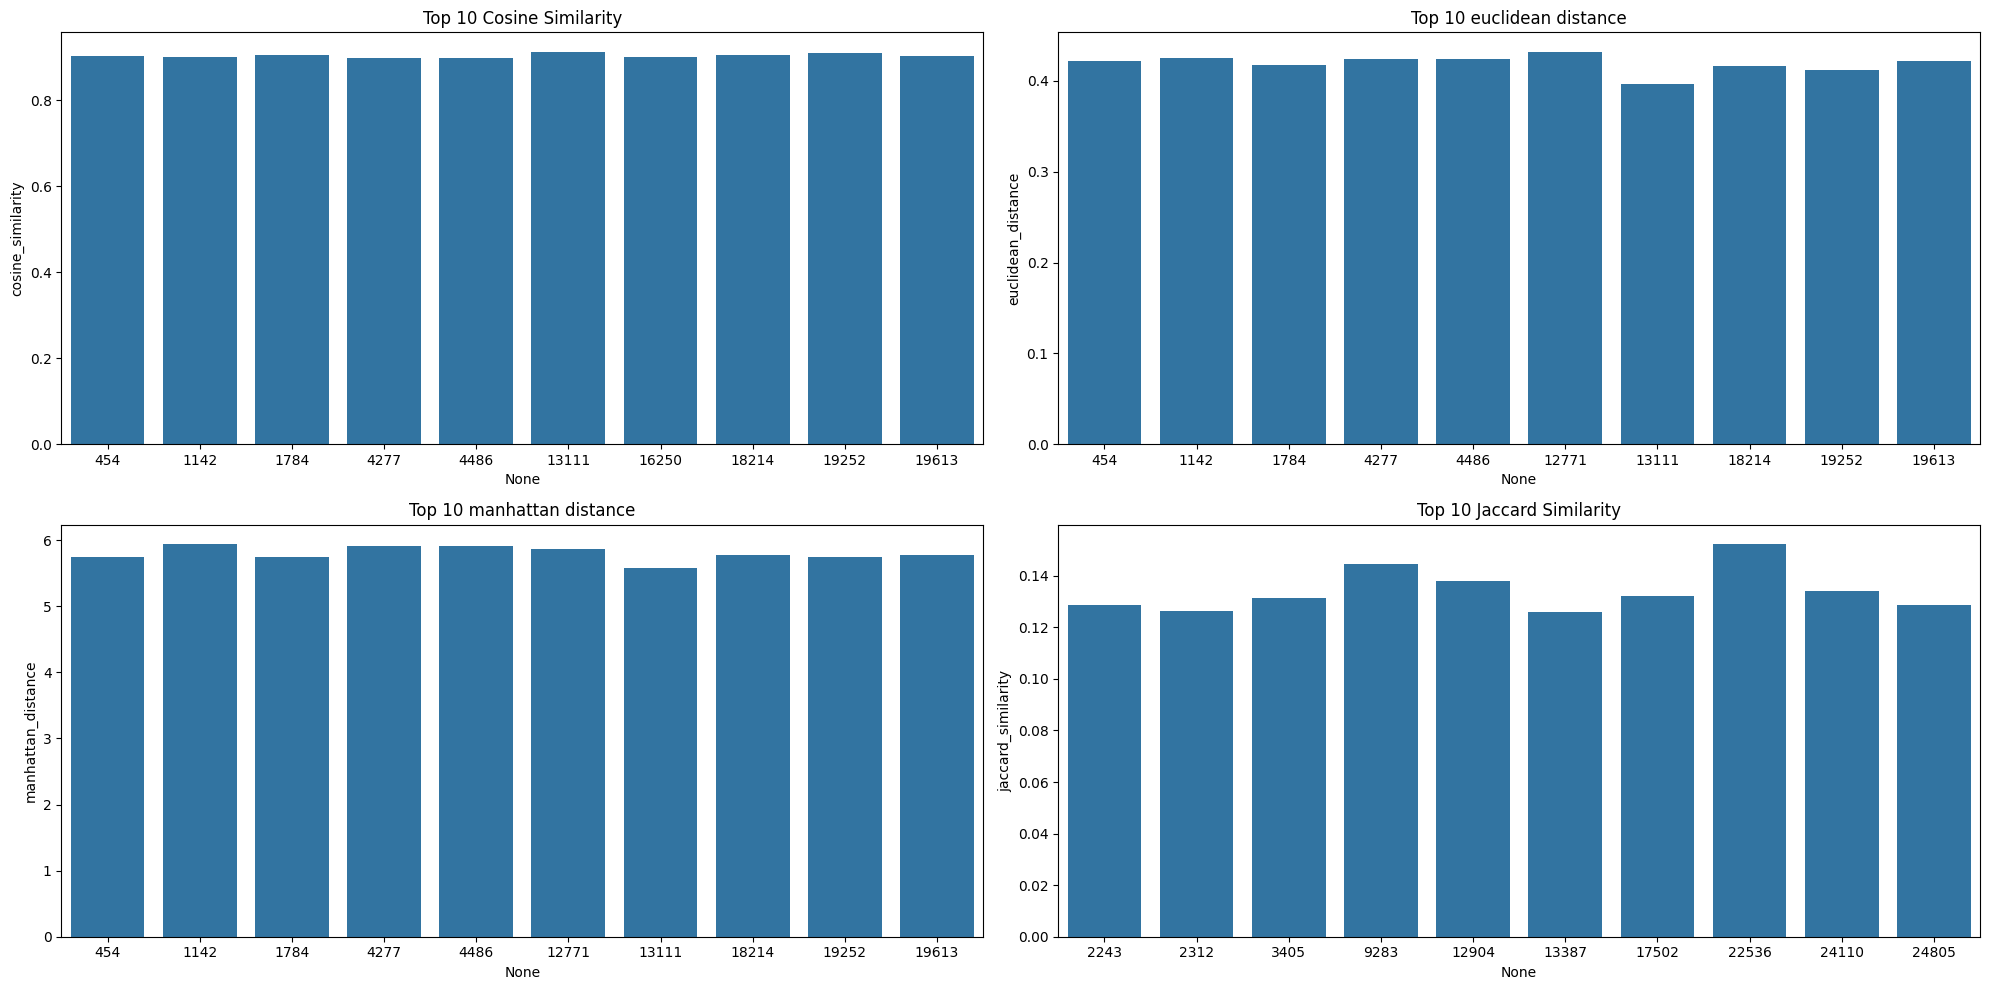

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

sns.barplot(ax=axes[0, 0], x=top_cosine.index, y=top_cosine["cosine_similarity"])
axes[0, 0].set_title("Top 10 Cosine Similarity")

sns.barplot(ax=axes[0, 1], x=top_euclidean.index, y=top_euclidean["euclidean_distance"])
axes[0, 1].set_title("Top 10 euclidean distance")

sns.barplot(ax=axes[1, 0], x=top_manhattan.index, y=top_manhattan["manhattan_distance"])
axes[1, 0].set_title("Top 10 manhattan distance")

sns.barplot(ax=axes[1, 1], x=top_jaccard.index, y=top_jaccard["jaccard_similarity"])
axes[1, 1].set_title("Top 10 Jaccard Similarity")

plt.tight_layout()
plt.show()

# contoh 2

In [ ]:
input_text = "My name is Eko Sulaison, and I am actively seeking a position in the beauty industry where I can utilize my extensive experience and passion for aesthetics. Over the past several years, I have honed my skills in various aspects of beauty care, including skincare, makeup application, and hair styling. I have worked in several renowned beauty salons and spas, where I have developed a deep understanding of the latest trends and techniques. My ability to connect with clients and understand their unique needs has always been my strength, allowing me to deliver personalized and satisfying beauty treatments. In addition to my hands-on experience, I have also pursued continuous education through workshops and certifications to stay updated with the evolving beauty standards and products. I am particularly adept at creating customized skincare routines and makeup looks that enhance the natural beauty of my clients. I am now looking for a dynamic and creative environment where I can further grow my career and contribute to the success of a reputable beauty establishment. I am confident that my dedication, skills, and positive attitude will be a valuable asset to any team in the beauty industry."

In [ ]:
input_text = re.sub(r'[^\w\s]', '', input_text)
tokens = word_tokenize(input_text)
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]
lemmatizer = WordNetLemmatizer()
tokens = [lemmatizer.lemmatize(word) for word in tokens]
input_text = ' '.join(tokens)

In [ ]:
def get_average_word2vec(tokens, model, num_features):
    valid_words = [word for word in tokens if word in model]
    if not valid_words:
        return np.zeros(num_features)
    return np.mean([model[word] for word in valid_words], axis=0)

corpus_tokens = [word_tokenize(re.sub(r'[^\w\s]', '', doc.lower())) for doc in dataset["deskripsi_keterampilan_final"]]
corpus_tokens = [[lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] for tokens in corpus_tokens]

num_features = 300
corpus_embeddings = np.array([get_average_word2vec(tokens, model, num_features) for tokens in corpus_tokens])
input_tokens = word_tokenize(input_text)
input_embedding = get_average_word2vec(input_tokens, model, num_features)

In [ ]:
cosine_similarities = cosine_similarity([input_embedding], corpus_embeddings).flatten()
dataset["cosine_similarity"] = cosine_similarities

In [ ]:
euclidean_distance = euclidean_distances([input_embedding], corpus_embeddings).flatten()
dataset["euclidean_distance"] = euclidean_distance

In [ ]:
manhattan_distance = manhattan_distances([input_embedding], corpus_embeddings).flatten()
dataset["manhattan_distance"] = manhattan_distance

In [ ]:
def jaccard_similarity(s1, s2):
    s1 = set(s1.split())
    s2 = set(s2.split())
    return len(s1 & s2) / len(s1 | s2)
jaccard_similarities = np.array([jaccard_similarity(' '.join(input_tokens), ' '.join(tokens)) for tokens in corpus_tokens])
dataset["jaccard_similarity"] = jaccard_similarities

In [ ]:
def dice_coefficient(s1, s2):
    s1 = set(s1.split())
    s2 = set(s2.split())
    return 2 * len(s1 & s2) / (len(s1) + len(s2))
dice_coefficients = np.array([dice_coefficient(' '.join(input_tokens), ' '.join(tokens)) for tokens in corpus_tokens])

In [ ]:
dataset["dice_coefficient"] = dice_coefficients

In [ ]:
def pearson_corr(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0
    return pearsonr(x, y)[0]
pearson_correlations = np.array([pearson_corr(input_embedding, emb) for emb in corpus_embeddings])
dataset["pearson_correlation"] = pearson_correlations

In [ ]:
def wmd_distance(s1, s2, model):
    s1_words = s1.split()
    s2_words = s2.split()

    s1_words = [word for word in s1_words if word in model]
    s2_words = [word for word in s2_words if word in model]

    if not s1_words or not s2_words:
        return float('inf')

    return model.wmdistance(s1_words, s2_words)
wmd_distances = np.array([wmd_distance(' '.join(input_tokens), ' '.join(tokens), model) for tokens in corpus_tokens])
dataset["wmd_distance"] = wmd_distances

In [ ]:
def bhattacharyya_distance(p, q):
    p = np.sqrt(np.abs(p))
    q = np.sqrt(np.abs(q))
    return -np.log(np.sum(p * q) + 1e-10)

def bhattacharyya_distance_from_vector(x, y):
    p = x / (np.sum(x) + 1e-10)
    q = y / (np.sum(y) + 1e-10)
    return bhattacharyya_distance(p, q)
bhattacharyya_distances = np.array([bhattacharyya_distance_from_vector(input_embedding, emb) for emb in corpus_embeddings])
dataset["bhattacharyya_distance"] = bhattacharyya_distances

In [ ]:
def kl_divergence(p, q):
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    p = p / np.sum(p)
    q = q / np.sum(q)
    return entropy(p, q)
kl_divergences = np.array([kl_divergence(input_embedding, emb) for emb in corpus_embeddings])
dataset["kl_divergence"] = kl_divergences

### Hasil

In [ ]:
top_similar = dataset.sort_values(by='cosine_similarity', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
20433,3757458613,166572,Design,assistant stylist,Full-time,OffsiteApply,not sponsored,bastrop,texas,united states,overview experience perfect blend deliberate purpose clear eye vision ulta beauty industry highly esteemed beauty leader share well expertise building authentic community create real sense plot bold strategic course excite innovation destine revolutionize industry think robust organizational support ever increase level investment healthy dose personal empowerment growth opportunity company unwavering strength stability future beauty service part transformation invite submit application may position open near future depend current business need impact daily basis opportunity learn experienced salon professional display artistry way draw potential newest trend idea enhance esteem set loose conquer world seriously could anything rewarding accomplish building personal professional rapport guest ulta beauty associates providing professional product recommendation part services learning assist elite master hair stylist mentor meeting exceed individual sale productivity goal attend mandatory education event workshop assist store duty e g fill salon retail display shelf adhere salon standard guest service cleanliness attending manager lead monthly business development meeting support personal business growth demonstrating personal style adhere ulta beauty dress code essential success qualified candidate year old cosmetology diploma license relevant work experience necessary additional requirement include basic understanding latest salon technique perform hair design color texture hair treatment makeup application ear piercing applicable basic understanding use equipment chemical need perform technical work basic understanding demonstrate recommend sell pro hair care makeup products developed communication skills ability work independently part team ability build maintain strong customer relationship special position requirement work flexible schedule include day evening weekend holiday work condition frequent mobility shift include reaching twisting neck movement frequent eye hand coordination guest service use computer continuous lifting move lb shift ability lift move lb le frequent stooping kneeling crouch shiftless frequent ability pull push rolling cart ability stand long period time shift climb ladder maintain balance shift ulta beauty nasdaq ulta possibility beautiful ulta beauty largest north american beauty retailer premier beauty destination cosmetic fragrance skin care product hair care product salon service bring possibility life power beauty every day store online product approximately well establish emerge beauty brand across category price point include ulta beauty private label ulta beauty also offer full service salon every store skin brow make service consider employment qualify applicant include arrest record conviction record criminal history manner consistent requirement applicable state local law include city los angeles fair chance initiative hire ordinance san francisco fair chance ordinance new york city fair chance act,0.889074,0.452456,6.273052,0.084548,0.155914,0.888186,0.978030,-2.075393,inf
28980,3749385752,166572,Other,brow wax expert,Full-time,OffsiteApply,not sponsored,independence,missouri,united states,overview experience perfect blend deliberate purpose clear eye vision ulta beauty industry highly esteemed beauty leader share well expertise building authentic community create real sense plot bold strategic course excite innovation destine revolutionize industry think robust organizational support ever increase level investment healthy dose personal empowerment growth opportunity company un

In [ ]:
top_similar['cosine_similarity']

20433    0.889074
28980    0.874900
5916     0.874900
17987    0.873636
2159     0.873374
6052     0.873374
1803     0.871367
1598     0.869875
29897    0.869875
23354    0.865941
Name: cosine_similarity, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='euclidean_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
20433,3757458613,166572,Design,assistant stylist,Full-time,OffsiteApply,not sponsored,bastrop,texas,united states,overview experience perfect blend deliberate purpose clear eye vision ulta beauty industry highly esteemed beauty leader share well expertise building authentic community create real sense plot bold strategic course excite innovation destine revolutionize industry think robust organizational support ever increase level investment healthy dose personal empowerment growth opportunity company unwavering strength stability future beauty service part transformation invite submit application may position open near future depend current business need impact daily basis opportunity learn experienced salon professional display artistry way draw potential newest trend idea enhance esteem set loose conquer world seriously could anything rewarding accomplish building personal professional rapport guest ulta beauty associates providing professional product recommendation part services learning assist elite master hair stylist mentor meeting exceed individual sale productivity goal attend mandatory education event workshop assist store duty e g fill salon retail display shelf adhere salon standard guest service cleanliness attending manager lead monthly business development meeting support personal business growth demonstrating personal style adhere ulta beauty dress code essential success qualified candidate year old cosmetology diploma license relevant work experience necessary additional requirement include basic understanding latest salon technique perform hair design color texture hair treatment makeup application ear piercing applicable basic understanding use equipment chemical need perform technical work basic understanding demonstrate recommend sell pro hair care makeup products developed communication skills ability work independently part team ability build maintain strong customer relationship special position requirement work flexible schedule include day evening weekend holiday work condition frequent mobility shift include reaching twisting neck movement frequent eye hand coordination guest service use computer continuous lifting move lb shift ability lift move lb le frequent stooping kneeling crouch shiftless frequent ability pull push rolling cart ability stand long period time shift climb ladder maintain balance shift ulta beauty nasdaq ulta possibility beautiful ulta beauty largest north american beauty retailer premier beauty destination cosmetic fragrance skin care product hair care product salon service bring possibility life power beauty every day store online product approximately well establish emerge beauty brand across category price point include ulta beauty private label ulta beauty also offer full service salon every store skin brow make service consider employment qualify applicant include arrest record conviction record criminal history manner consistent requirement applicable state local law include city los angeles fair chance initiative hire ordinance san francisco fair chance ordinance new york city fair chance act,0.889074,0.452456,6.273052,0.084548,0.155914,0.888186,0.978030,-2.075393,inf
5916,3694105601,166572,Other,brow wax expert,Full-time,OffsiteApply,not sponsored,woodbury,minnesota,united states,overview experience perfect blend deliberate purpose clear eye vision ulta beauty industry highly esteemed beauty leader share well expertise building authentic community create real sense plot bold strategic course excite innovation destine revolutionize industry think robust organizational support ever increase level investment healthy dose personal empowerment growth opportunity company unwave

In [ ]:
top_similar['euclidean_distance']

20433    0.452456
5916     0.473680
28980    0.473680
6052     0.477989
2159     0.477989
17987    0.479273
1803     0.480782
29897    0.484594
1598     0.484594
28561    0.489376
Name: euclidean_distance, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='manhattan_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
20433,3757458613,166572,Design,assistant stylist,Full-time,OffsiteApply,not sponsored,bastrop,texas,united states,overview experience perfect blend deliberate purpose clear eye vision ulta beauty industry highly esteemed beauty leader share well expertise building authentic community create real sense plot bold strategic course excite innovation destine revolutionize industry think robust organizational support ever increase level investment healthy dose personal empowerment growth opportunity company unwavering strength stability future beauty service part transformation invite submit application may position open near future depend current business need impact daily basis opportunity learn experienced salon professional display artistry way draw potential newest trend idea enhance esteem set loose conquer world seriously could anything rewarding accomplish building personal professional rapport guest ulta beauty associates providing professional product recommendation part services learning assist elite master hair stylist mentor meeting exceed individual sale productivity goal attend mandatory education event workshop assist store duty e g fill salon retail display shelf adhere salon standard guest service cleanliness attending manager lead monthly business development meeting support personal business growth demonstrating personal style adhere ulta beauty dress code essential success qualified candidate year old cosmetology diploma license relevant work experience necessary additional requirement include basic understanding latest salon technique perform hair design color texture hair treatment makeup application ear piercing applicable basic understanding use equipment chemical need perform technical work basic understanding demonstrate recommend sell pro hair care makeup products developed communication skills ability work independently part team ability build maintain strong customer relationship special position requirement work flexible schedule include day evening weekend holiday work condition frequent mobility shift include reaching twisting neck movement frequent eye hand coordination guest service use computer continuous lifting move lb shift ability lift move lb le frequent stooping kneeling crouch shiftless frequent ability pull push rolling cart ability stand long period time shift climb ladder maintain balance shift ulta beauty nasdaq ulta possibility beautiful ulta beauty largest north american beauty retailer premier beauty destination cosmetic fragrance skin care product hair care product salon service bring possibility life power beauty every day store online product approximately well establish emerge beauty brand across category price point include ulta beauty private label ulta beauty also offer full service salon every store skin brow make service consider employment qualify applicant include arrest record conviction record criminal history manner consistent requirement applicable state local law include city los angeles fair chance initiative hire ordinance san francisco fair chance ordinance new york city fair chance act,0.889074,0.452456,6.273052,0.084548,0.155914,0.888186,0.978030,-2.075393,inf
1803,3693049749,166572,Sales,company sale manager,Full-time,OffsiteApply,sponsored,mount pleasant,south carolina,united states,overview experience place energy passion excitement place joy discovery uncommon artistry blend create exhilarate buy true beauty enthusiast ulta beauty transform world one shade one lash one cut time beauty powerful seek greater place vision mission live voice hear contribution value recognize growth opportunity abound consider ulta beauty nowhere else possibility quite beautiful imp

In [ ]:
top_similar['manhattan_distance']

20433    6.273052
1803     6.462543
6052     6.509106
2159     6.509106
1598     6.564766
29897    6.564766
5916     6.588372
28980    6.588372
28561    6.656377
17987    6.729136
Name: manhattan_distance, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='jaccard_similarity', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
1881,3693050153,69348938,Design,visual effect artist,Full-time,ComplexOnsiteApply,not sponsored,No Info,No Info,united states,cxe look hire vfx artist ongoing internal external project ideal candidate someone adept proficient edit vfx seek individual eager learn grow within company flexible schedule portfolio available ready share review encourage apply responsibility follow provide script screenplay outline ensure edit vfx align creative vision enhance footage incorporate sound element include music selection voice apply visual effect vfx enhance quality impact footage work internal post production creative director bring creative vision life enhance correct lighting color flawed footage achieve desired visual aesthetic collaborate team ensure final product meet highest standard quality creativity requirement proven experience video editing visual effect strong portfolio showcasing skill proficiency relevant editing software vfx tool e g adobe premiere pro effect etc solid understanding storytelling pacing visual aesthetic deliver compelling content strong communication skill effectively work director client creative team ability adapt project requirement provide creative solution dynamic environment detail orient mindset commitment deliver polish visually appeal work continuous learn mindset willingness stay updated industry trend advancement passionate video editing visual effect excite contribute expertise collaborative creative team encourage apply share portfolio u skill play vital role craft exceptional content resonate audience fulfill creative vision project,0.809355,0.605525,8.334177,0.112195,0.201754,0.807777,0.990678,-1.989296,inf
13526,3701318426,2473798,Human Resources,corporate recruiter,Full-time,ComplexOnsiteApply,not sponsored,houston,texas,united states,consider people base texas two function role recruiter service play pivotal role identify engage top tier talent client across diverse industry expertise source screening assess candidate drive success client recruitment initiative collaborate closely hiring manager develop deep understanding staffing need craft compel job description execute strategic source strategy attract qualified candidate exceptional communication skill ability foster positive candidate experience ensure seamless recruitment process stay abreast industry trend enable provide valuable insight optimize hire strategy join u revolutionize recruitment deliver efficient tailor high quality talent acquisition solution internal recruiter responsible source attract select top tier talent join organization collaborate closely department manager identify staff need develop comprehensive job description implement effective recruitment strategy attract engage qualified candidate exceptional interpersonal skill ensure positive candidate experience throughout hiring process ability evaluate candidate skill cultural fit contribute build high performing workforce stay date industry trend best practice continuously enhance recruitment process contribute company growth success join u shape team foster dynamic thriving work environment,0.783333,0.648695,8.847828,0.105556,0.190955,0.781428,0.981592,-1.983375,inf
15924,3749347009,316322,Management,assistant project manager commercial construction,Full-time,SimpleOnsiteApply,sponsored,austin,texas,united states,commercial construction assistant project manager austin texs motivate aspire senior project engineer assistant project manager look company prioritize professional growth development keen interest commercial construction particularly build office building hotel life science education healthcare building exciting opportunity leading commercial construct

In [ ]:
top_similar['jaccard_similarity']

1881     0.112195
13526    0.105556
15924    0.103139
3242     0.102362
3879     0.102362
3203     0.101523
13877    0.101266
21224    0.100917
3217     0.100386
2654     0.099602
Name: jaccard_similarity, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='dice_coefficient', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
1881,3693050153,69348938,Design,visual effect artist,Full-time,ComplexOnsiteApply,not sponsored,No Info,No Info,united states,cxe look hire vfx artist ongoing internal external project ideal candidate someone adept proficient edit vfx seek individual eager learn grow within company flexible schedule portfolio available ready share review encourage apply responsibility follow provide script screenplay outline ensure edit vfx align creative vision enhance footage incorporate sound element include music selection voice apply visual effect vfx enhance quality impact footage work internal post production creative director bring creative vision life enhance correct lighting color flawed footage achieve desired visual aesthetic collaborate team ensure final product meet highest standard quality creativity requirement proven experience video editing visual effect strong portfolio showcasing skill proficiency relevant editing software vfx tool e g adobe premiere pro effect etc solid understanding storytelling pacing visual aesthetic deliver compelling content strong communication skill effectively work director client creative team ability adapt project requirement provide creative solution dynamic environment detail orient mindset commitment deliver polish visually appeal work continuous learn mindset willingness stay updated industry trend advancement passionate video editing visual effect excite contribute expertise collaborative creative team encourage apply share portfolio u skill play vital role craft exceptional content resonate audience fulfill creative vision project,0.809355,0.605525,8.334177,0.112195,0.201754,0.807777,0.990678,-1.989296,inf
13526,3701318426,2473798,Human Resources,corporate recruiter,Full-time,ComplexOnsiteApply,not sponsored,houston,texas,united states,consider people base texas two function role recruiter service play pivotal role identify engage top tier talent client across diverse industry expertise source screening assess candidate drive success client recruitment initiative collaborate closely hiring manager develop deep understanding staffing need craft compel job description execute strategic source strategy attract qualified candidate exceptional communication skill ability foster positive candidate experience ensure seamless recruitment process stay abreast industry trend enable provide valuable insight optimize hire strategy join u revolutionize recruitment deliver efficient tailor high quality talent acquisition solution internal recruiter responsible source attract select top tier talent join organization collaborate closely department manager identify staff need develop comprehensive job description implement effective recruitment strategy attract engage qualified candidate exceptional interpersonal skill ensure positive candidate experience throughout hiring process ability evaluate candidate skill cultural fit contribute build high performing workforce stay date industry trend best practice continuously enhance recruitment process contribute company growth success join u shape team foster dynamic thriving work environment,0.783333,0.648695,8.847828,0.105556,0.190955,0.781428,0.981592,-1.983375,inf
15924,3749347009,316322,Management,assistant project manager commercial construction,Full-time,SimpleOnsiteApply,sponsored,austin,texas,united states,commercial construction assistant project manager austin texs motivate aspire senior project engineer assistant project manager look company prioritize professional growth development keen interest commercial construction particularly build office building hotel life science education healthcare building exciting opportunity leading commercial construct

In [ ]:
top_similar['dice_coefficient']

1881     0.201754
13526    0.190955
15924    0.186992
3242     0.185714
3879     0.185714
3203     0.184332
13877    0.183908
21224    0.183333
3217     0.182456
2654     0.181159
Name: dice_coefficient, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='pearson_correlation', ascending=False).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
20433,3757458613,166572,Design,assistant stylist,Full-time,OffsiteApply,not sponsored,bastrop,texas,united states,overview experience perfect blend deliberate purpose clear eye vision ulta beauty industry highly esteemed beauty leader share well expertise building authentic community create real sense plot bold strategic course excite innovation destine revolutionize industry think robust organizational support ever increase level investment healthy dose personal empowerment growth opportunity company unwavering strength stability future beauty service part transformation invite submit application may position open near future depend current business need impact daily basis opportunity learn experienced salon professional display artistry way draw potential newest trend idea enhance esteem set loose conquer world seriously could anything rewarding accomplish building personal professional rapport guest ulta beauty associates providing professional product recommendation part services learning assist elite master hair stylist mentor meeting exceed individual sale productivity goal attend mandatory education event workshop assist store duty e g fill salon retail display shelf adhere salon standard guest service cleanliness attending manager lead monthly business development meeting support personal business growth demonstrating personal style adhere ulta beauty dress code essential success qualified candidate year old cosmetology diploma license relevant work experience necessary additional requirement include basic understanding latest salon technique perform hair design color texture hair treatment makeup application ear piercing applicable basic understanding use equipment chemical need perform technical work basic understanding demonstrate recommend sell pro hair care makeup products developed communication skills ability work independently part team ability build maintain strong customer relationship special position requirement work flexible schedule include day evening weekend holiday work condition frequent mobility shift include reaching twisting neck movement frequent eye hand coordination guest service use computer continuous lifting move lb shift ability lift move lb le frequent stooping kneeling crouch shiftless frequent ability pull push rolling cart ability stand long period time shift climb ladder maintain balance shift ulta beauty nasdaq ulta possibility beautiful ulta beauty largest north american beauty retailer premier beauty destination cosmetic fragrance skin care product hair care product salon service bring possibility life power beauty every day store online product approximately well establish emerge beauty brand across category price point include ulta beauty private label ulta beauty also offer full service salon every store skin brow make service consider employment qualify applicant include arrest record conviction record criminal history manner consistent requirement applicable state local law include city los angeles fair chance initiative hire ordinance san francisco fair chance ordinance new york city fair chance act,0.889074,0.452456,6.273052,0.084548,0.155914,0.888186,0.978030,-2.075393,inf
5916,3694105601,166572,Other,brow wax expert,Full-time,OffsiteApply,not sponsored,woodbury,minnesota,united states,overview experience perfect blend deliberate purpose clear eye vision ulta beauty industry highly esteemed beauty leader share well expertise building authentic community create real sense plot bold strategic course excite innovation destine revolutionize industry think robust organizational support ever increase level investment healthy dose personal empowerment growth opportunity company unwave

In [ ]:
top_similar['pearson_correlation']

20433    0.888186
5916     0.873924
28980    0.873924
17987    0.872942
6052     0.872337
2159     0.872337
1803     0.870303
1598     0.868912
29897    0.868912
28510    0.864836
Name: pearson_correlation, dtype: float64

In [ ]:
filtered_dataset = dataset[dataset["wmd_distance"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='wmd_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
13877,3701322359,9499,Management,nail technician part time,Part-time,OffsiteApply,not sponsored,fort meade,florida,united states,salon technician responsible provide salon clientele professional service relate care treatment hair nail skin position report salon manager desk manager position nonexempt salon look next great talent nail specialist positive attitude team player mentality would like talk high volume salon spa specialize natural nail manicure pedicure gel shellac service join team need passion beauty industry thirst keep learning desire love job believe education never end whether recent graduate year business position require active participation ongoing education provide opportunity participate house outside education class highest trained individual industry salon locate high traffic premier mall location throughout southeast look best nail specialist industry participate rapid growth position description nail technician report salon manager responsible provide salon clientele professional service relate care treatment nail skin client service meeting exceed personal service retail sale goal acknowledge client within reasonable time client check salon build client base recruit new request client maintain customer client card provide quality professional service technical skill prescribe appropriate retail product client respond professionally customer service issue promptly address complaint exhibit good communication skill ongoing continue education product service current issue relate industry salon personal presentation ensure personal work area salon meet exceed state board regulation perform basic salon house keep duty cleaning stocking client card effectively organize time resource meet sale goal communication salon management regard issue need meet salon guideline attendance tardiness maintain updated professional appearance meet salon dress code education experience must possess valid current board certify license two five year experience cosmetology cosmetic industry prefer physical ability use computer keyboard standard telephone related business equipment ability work chemical chemical compound ability lift pound,0.837924,0.537754,7.472529,0.101266,0.183908,0.836551,0.957960,-2.070224,inf
13789,3701321389,9499,Management,hair stylist part time,Part-time,OffsiteApply,not sponsored,greater hattiesburg area,mississippi,united states,salon technician responsible provide salon clientele professional service relate care treatment hair nail skin position report salon manager desk manager position nonexempt salon look next great talent stylist creative motivate inspire want talk look goal orient team player passion hair industry thirst keep learn important want love job believe education never end whether recent graduate year behind chair offer weekly salon training talented stylist business addition provide opportunity participate outside education class biggest name salon industry salon locate high traffic premier mall location throughout southeast look best stylist industry participate rapid growth position description hair stylist report salon manager responsible provide salon clientele professional service relate care treatment hair client service meeting exceed personal service retail sale goal acknowledge client within reasonable time client check salon build client base recruit new request client maintain customer client card provide quality professional service technical skill prescribe appropriate retail product client respond professionally customer service issue promptly address complaint exhibit good communication skill ongoing continue education product service current issue relate industry salon p

In [ ]:
top_similar['wmd_distance']

13877    0.957960
13789    0.958638
13788    0.958638
29325    0.970050
20433    0.978030
13526    0.981592
17823    0.983641
1881     0.990678
3203     0.992434
3242     0.993734
Name: wmd_distance, dtype: float64

In [ ]:
top_similar = dataset.sort_values(by='bhattacharyya_distance', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence
1521,3693048426,18953334,Design,bridal stylist,Part-time,ComplexOnsiteApply,not sponsored,san francisco bay area,california,united states,responsibility lead co lead styling appointment bride guest stay update brand product knowledge include bridal trend prepare appointment style fit communicate bride appointment provide outstanding customer service qualification retail sale experience must weekend friday sunday availability interest bridal fashion positive energize attitude,0.769106,0.658455,9.112191,0.057377,0.108527,0.772034,1.093866,-4.774733,inf
10382,3699085913,28389122,Business Development,business development manager,Full-time,ComplexOnsiteApply,not sponsored,salt lake city,utah,united states,client full service logistics provider seek business development manager join team salt lake city area business development manager responsible identify pursue new business opportunity develop implement sale strategy build relationship client prospect requirement minimum year experience business development salt lake city area must international freight forwarding logistics industry air ocean benefit competitive salary package attractive commission program gross profit dollar one cap sunset car allowance business relate travel comprehensive medical dental retirement plan sound like perfect fit hesitate apply relative title include sale representative account executive business development executive sale associate sale manager sale account manager sale development representative sale account executive sale relationship manager sale development executive national account manager sale business development manager new business development manager account development manager business development executive business development manager international sale manager global sale manager senior account executive sale executive sale account executive national business development manager director business development global sale executive strategic account executive,0.583506,0.902711,12.743725,0.030303,0.058824,0.585666,1.180379,-4.286620,inf
6504,3694107931,2678,Quality Assurance,producciónorth general,Full-time,OffsiteApply,not sponsored,dayton,virginia,united states,un más sus ten table cultivar tu carrera al global de cargill que con que en usar man eras sus ten tables de nut rir al mundo este puesto está den tro del de sal de cargill con el que ali men tic ios de alta cali dad una amp lia gama de oper adores de de de comestible fabric antes export adores dayton va tipo de emp leo tiempo comp leto tiempo medio hr bono de bene fic ios dental de la vista marathon health clinic centro de salud por el pag adas k con contrib uci ones de cargill de fsas de de vida de asistencia al eap de des cuentos para res pons abi lid ades mane jar pavo la el área de trabajo e legal para en los estados unidos sin la de un de visa mayor de años de edad pre via en de pavo en de en de de trabajo en los los una llamada telef nica de un de área en que esta el de la con igualdad de,0.183683,1.812264,25.095314,0.000000,0.000000,0.184535,1.297540,-4.036804,inf
5547,3694100610,81219955,Health Care Provider,psychotherapist private practice,Full-time,SimpleOnsiteApply,not sponsored,brooklyn,new york,united states,ffs start see com detail,0.439139,1.269858,17.001939,0.000000,0.000000,0.440648,1.276240,-3.945775,inf
18291,3757466489,425698,Information Technology,director franchise sale,Contract,ComplexOnsiteApply,not sponsored,No Info,No Info,united states,job description position director franchise sales duration direct hire location remote job description experience job description the director franchise sale report vice president sale responsible franchise sale activity r

In [ ]:
top_similar['bhattacharyya_distance']

1521    -4.774733
10382   -4.286620
6504    -4.036804
5547    -3.945775
18291   -3.940493
1965    -3.826742
22929   -3.753492
19124   -3.738801
16715   -3.716974
10632   -3.598754
Name: bhattacharyya_distance, dtype: float64

In [ ]:
filtered_dataset = dataset[dataset["kl_divergence"] != float('inf')]
top_similar = filtered_dataset.sort_values(by='kl_divergence', ascending=True).head(10)
top_similar

,id_pekerjaan,id_perusahaan,skill,job title,jenis_pekerjaan,registration_type,category sponsor,city,state,county,deskripsi_keterampilan_final,cosine_similarity,euclidean_distance,manhattan_distance,jaccard_similarity,dice_coefficient,pearson_correlation,wmd_distance,bhattacharyya_distance,kl_divergence


In [ ]:
print(top_similar['kl_divergence'])

Series([], Name: kl_divergence, dtype: float64)
